In [ ]:
!pip3 install pyro-ppl
!nvidia-smi

     |████████████████████████████████| 614kB 9.3MB/s 
Tue Mar  2 00:05:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

In [ ]:
# Normalising Flows - Introduction (Part 1)
# https://pyro.ai/examples/normalizing_flows_i.html#Conditional-versus-Joint-Distributions

# %% imports
import torch
import pyro
import pandas as pd
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os
smoke_test = ('CI' in os.environ)

# %% using gpu for larger VCSN data
# https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# marker size
s = 0.5

Using device: cuda



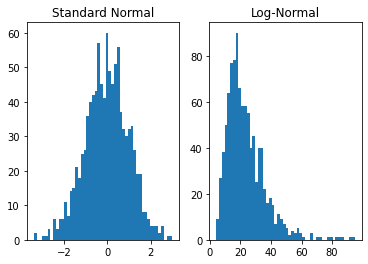

In [ ]:
# %% base class of X and class for transform exp(.)

dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
exp_transform = T.ExpTransform()

# %% create transformed dist class (dist of noise -> list of transforms, encapsulates dist by applying transforms in seq.)

dist_y = dist.TransformedDistribution(dist_x, [exp_transform])

# %% producing the log normal dist by adding an affine transform

dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
affine_transform = T.AffineTransform(loc=3, scale=0.5)
exp_transform = T.ExpTransform()
dist_y = dist.TransformedDistribution(dist_x, [affine_transform, exp_transform])

plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Log-Normal')
plt.show()

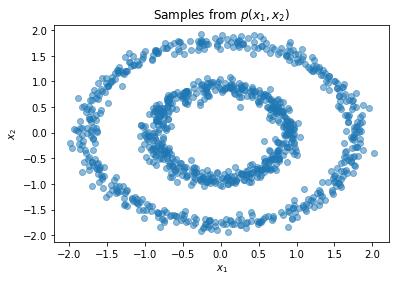

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


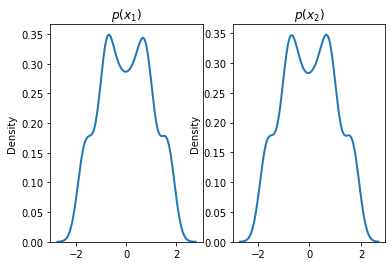

In [ ]:
# %% learnable uni variate distributions

import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_2)$')
plt.show()

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

# %% read vcsn data 

rad_soil_df = pd.read_csv("/content/gdrive/My Drive/PhD/posters/vcsn_rad_solim.csv")[['time','lon', 'lat', 'soilm', 'rad']]

rain_soil_df = pd.read_csv("/content/gdrive/My Drive/PhD/posters/vcsn_rain_solim.csv")[['time','lon', 'lat', 'soilm', 'rain']]

print(rad_soil_df.columns)
print(rain_soil_df.columns)

Mounted at /content/gdrive
Index(['time', 'lon', 'lat', 'soilm', 'rad'], dtype='object')
Index(['time', 'lon', 'lat', 'soilm', 'rain'], dtype='object')


In [ ]:
# %% example of relationship between soilm and rad
rad_soil_df_filt1 = rad_soil_df[rad_soil_df['time'] == 0]
rad_soil_df_filt2 = rad_soil_df[rad_soil_df['time'] == 242]
rad_soil_df_filt3 = rad_soil_df[rad_soil_df['time'] == 2646]

if False:
  plt.figure(1)
  plt.scatter(rad_soil_df_filt1['soilm'], rad_soil_df_filt1['rad'], alpha=0.1)
  plt.scatter(rad_soil_df_filt2['soilm'], rad_soil_df_filt2['rad'], alpha=0.1)
  plt.scatter(rad_soil_df_filt3['soilm'], rad_soil_df_filt3['rad'], alpha=0.1)

# select first million rows to save some ram
rad_soil_np = pd.DataFrame(rad_soil_df[['soilm','rad']]).head(n=100000).to_numpy()

X = rad_soil_np

len(rad_soil_np)

# %% example of relationship between soilm and rain
rain_soil_df_filt1 = rain_soil_df[rad_soil_df['time'] == 0]
rain_soil_df_filt2 = rain_soil_df[rad_soil_df['time'] == 242]
rain_soil_df_filt3 = rain_soil_df[rad_soil_df['time'] == 2646]

if False:
  plt.figure(2)
  plt.scatter(rain_soil_df_filt1['soilm'], rain_soil_df_filt1['rain'], alpha=0.1)
  plt.scatter(rain_soil_df_filt2['soilm'], rain_soil_df_filt2['rain'], alpha=0.1)
  plt.scatter(rain_soil_df_filt3['soilm'], rain_soil_df_filt3['rain'], alpha=0.1)

# select first 10 timesteps (months) to save some ram
first_ten = pd.unique(rain_soil_df[["time"]].squeeze())[0:9].tolist()
first_ten_df = rain_soil_df[rain_soil_df.isin(first_ten)[["time"]].values]
print(first_ten_df)

rain_soil_np = first_ten_df[['rain','soilm']].to_numpy()
# soilm = x2
# rain = x1

#pd.DataFrame(rain_soil_df[['soilm','rain']]).head(n=100000).to_numpy()

X = rain_soil_np

len(rain_soil_np)

        time      lon     lat      soilm   rain
0          0  167.475 -47.275  -3.409677  189.6
1          0  167.525 -47.275  -3.129032  192.3
2          0  167.475 -47.225  -3.312903  191.5
3          0  167.525 -47.225   7.680645  249.0
4          0  167.575 -47.225   7.912903  251.8
...      ...      ...     ...        ...    ...
103414   242  172.825 -34.475  -9.483333   92.3
103415   242  172.875 -34.475  -9.640000   88.6
103416   242  172.925 -34.475  -9.900000   86.5
103417   242  172.975 -34.475 -10.106667   85.3
103418   242  172.875 -34.425 -10.326667   81.8

[103419 rows x 5 columns]


103419

In [ ]:
# %% using spline transform

base_dist = dist.Normal(torch.zeros(2, device=device), torch.ones(2, device=device))
spline_transform = T.Spline(2, count_bins=16).cuda()
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

# %% train spline on MLE objective using SGD

steps = 1 if smoke_test else 1001

# define scaler so we can reverse transform
# https://stackoverflow.com/questions/38058774/scikit-learn-how-to-scale-back-the-y-predicted-result

# Scale data
scalerx = StandardScaler().fit(X)
X = scalerx.transform(X)

dataset = torch.tensor(X, dtype=torch.float, device=device)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.5073108673095703
step: 200, loss: 0.9996457099914551
step: 400, loss: 0.9747014045715332
step: 600, loss: 0.9705828428268433
step: 800, loss: nan
step: 1000, loss: nan


In [ ]:
# %% plot samples drawn from learned transformed dist
if False:
  X_flow = flow_dist.sample(torch.Size([10000,])).cpu().detach().numpy()
  plt.title('Joint Distribution of Soil Moisture and Rainfall (scaled)')
  plt.xlabel('soil moisture')
  plt.ylabel('rain')
  plt.scatter(X[:,0], X[:,1], label='data', alpha=0.1)
  plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.1)
  plt.legend()
  plt.show()

  plt.subplot(1, 2, 1)
  sns.distplot(X[:,0], hist=False, kde=True,
              bins=None,
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 2},
              label='data')
  sns.distplot(X_flow[:,0], hist=False, kde=True,
              bins=None, color='firebrick',
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 2},
              label='flow')
  plt.title(r'$p(x_1)$')
  plt.subplot(1, 2, 2)
  sns.distplot(X[:,1], hist=False, kde=True,
              bins=None,
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 2},
              label='data')
  sns.distplot(X_flow[:,1], hist=False, kde=True,
              bins=None, color='firebrick',
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 2},
              label='flow')
  plt.title(r'$p(x_2)$')
  plt.show()

In [ ]:
# %% multivariate section  - bivariate flow - single spline coupling layer

base_dist = dist.Normal(torch.zeros(2, device=device), torch.ones(2, device=device))
spline_transform = T.spline_coupling(2, count_bins=16).cuda()
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

# %% train bivariate flow on toy data set

# adjust train steps from 5k to 10k
steps = 1 if smoke_test else 5001
dataset = torch.tensor(X, dtype=torch.float, device=device)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=8e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.088452100753784
step: 500, loss: 1.4302173852920532
step: 1000, loss: 1.4126185178756714
step: 1500, loss: 1.4100098609924316
step: 2000, loss: 1.4049960374832153
step: 2500, loss: 1.403167724609375
step: 3000, loss: 1.4073764085769653
step: 3500, loss: 1.4000717401504517
step: 4000, loss: 1.3986587524414062
step: 4500, loss: 1.3990145921707153
step: 5000, loss: 1.397953987121582


In [ ]:
# %% plot results
if False:
  # adjust sampling n = 100k (same as train dataset)
  X_flow = flow_dist.sample(torch.Size([10000,])).cpu().detach().numpy()
  plt.title('Joint Distribution of Soil Moisture and Rainfall (scaled)')
  plt.xlabel('soil moisture')
  plt.ylabel('rain')
  plt.scatter(X[:,0], X[:,1], label='data', alpha=0.05)
  plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.05)
  plt.legend()
  plt.show()

  plt.subplot(1, 2, 1)
  sns.distplot(X[:,0], hist=False, kde=True,
              bins=None,
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 2},
              label='data')
  sns.distplot(X_flow[:,0], hist=False, kde=True,
              bins=None, color='firebrick',
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 2},
              label='flow')
  plt.title(r'$p(x_1)$')
  plt.title('soil moisture')
  plt.subplot(1, 2, 2)
  sns.distplot(X[:,1], hist=False, kde=True,
              bins=None,
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 2},
              label='data')
  sns.distplot(X_flow[:,1], hist=False, kde=True,
              bins=None, color='firebrick',
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 2},
              label='flow')
  plt.title(r'$p(x_2)$')
  plt.xlabel("rainfall")
  plt.show()

In [ ]:
# %% conditional vs joint dists.  - create univariate dist

dist_base = dist.Normal(torch.zeros(1, device=device), torch.ones(1, device=device))
x1_transform = T.spline(1).cuda()
dist_x1 = dist.TransformedDistribution(dist_base, [x1_transform])

# %%  create conditioned transform

x2_transform = T.conditional_spline(1, context_dim=1).cuda()
dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base, [x2_transform])

# %% draw sample from conditioned transform

x1 = torch.ones(1, device=device)
print(dist_x2_given_x1.condition(x1).sample())

# %% combine two distributions and train on toy data

steps = 1 if smoke_test else 5001
modules = torch.nn.ModuleList([x1_transform, x2_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=3e-3)
x1 = dataset[:,0][:,None]
x2 = dataset[:,1][:,None]
for step in range(steps):
    optimizer.zero_grad()
    ln_p_x1 = dist_x1.log_prob(x1)
    ln_p_x2_given_x1 = dist_x2_given_x1.condition(x1.detach()).log_prob(x2.detach())
    loss = -(ln_p_x1 + ln_p_x2_given_x1).mean()
    loss.backward()
    optimizer.step()
    dist_x1.clear_cache()
    dist_x2_given_x1.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

tensor([-0.6625], device='cuda:0')
step: 0, loss: 3.926201343536377
step: 500, loss: 1.5167256593704224
step: 1000, loss: 1.4741548299789429
step: 1500, loss: 1.4661262035369873
step: 2000, loss: 1.459318995475769
step: 2500, loss: 1.4574313163757324
step: 3000, loss: 1.4567350149154663
step: 3500, loss: 1.454877257347107
step: 4000, loss: 1.454575538635254
step: 4500, loss: 1.4534038305282593
step: 5000, loss: 1.4520787000656128


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

tensor([1.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


tensor([1.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


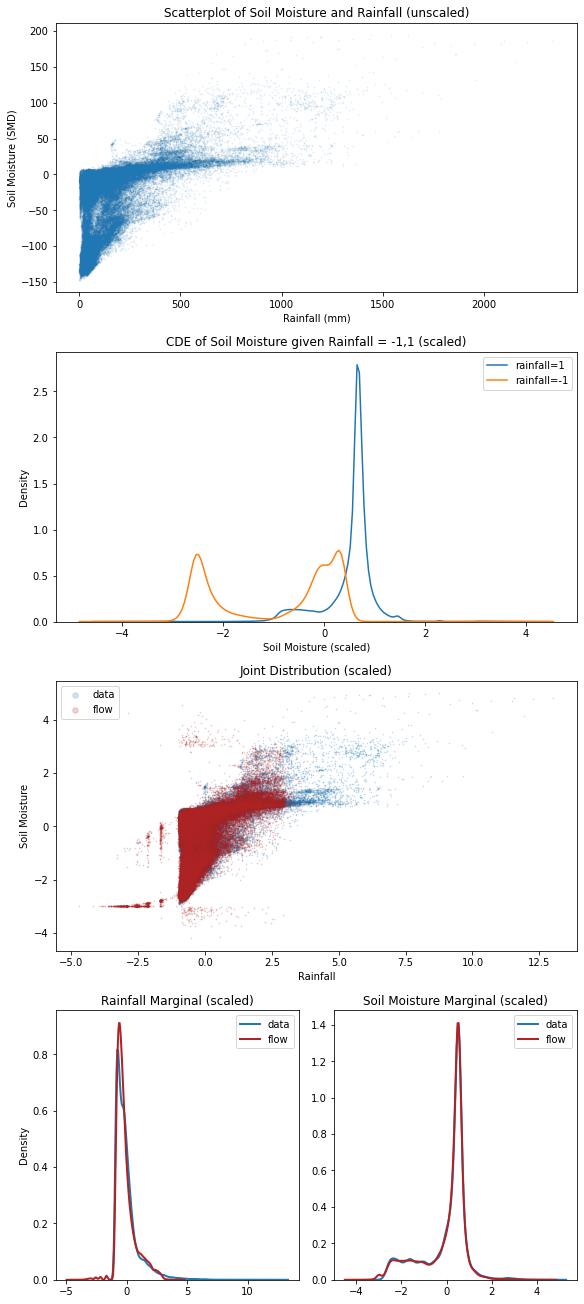

In [19]:
# %% plot results
X = torch.cat((x1, x2), dim=-1).cpu().detach().numpy()
x1_flow = dist_x1.sample(torch.Size([103419,]))
x2_flow = dist_x2_given_x1.condition(x1_flow).sample(torch.Size([103419,]))
X_flow = torch.cat((x1_flow, x2_flow), dim=-1).cpu().detach().numpy()

# setup multi-plot
fig3 = plt.figure(constrained_layout=True,figsize=[8,18])
gs = fig3.add_gridspec(4, 2)
ax1 = fig3.add_subplot(gs[0, :])
ax1.set_title('1')
ax2 = fig3.add_subplot(gs[1, :])
ax2.set_title('2')
ax3 = fig3.add_subplot(gs[2, :])
ax3.set_title('3')
ax4 = fig3.add_subplot(gs[3, 0])
ax4.set_title('4')
ax5 = fig3.add_subplot(gs[3, 1])
ax5.set_title('5')

# data scatterplot
# select relevant vars
# plt.figure(3)
ax1.scatter(first_ten_df['rain'],first_ten_df['soilm'], alpha=0.1,s=s)
ax1.set_title("Scatterplot of Soil Moisture and Rainfall (unscaled)")
ax1.set_ylabel("Soil Moisture (SMD)")
ax1.set_xlabel("Rainfall (mm)")
#plt.savefig('scatterplot_rain_moisture.png', bbox_inches='tight')
#plt.show()

# joint dist scatterplot
ax3.set_title('Joint Distribution (scaled)') 
ax3.set_xlabel('Rainfall')
ax3.set_ylabel('Soil Moisture')
ax3.scatter(X[:,0], X[:,1], label='data', alpha=0.2,s=s)
ax3.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.2,s=s)
lgnd = ax3.legend(scatterpoints=1)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
#ax3.legend()
#plt.savefig('joint.png', bbox_inches='tight')
#plt.show()

#plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,ax=ax4,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,ax=ax4,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
ax4.legend()
ax4.set_title('Rainfall Marginal (scaled)')
#plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,ax=ax5,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,ax=ax5,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
ax5.legend()
ax5.set_ylabel('')
ax5.set_title('Soil Moisture Marginal (scaled)')
#plt.savefig('marginals.png', bbox_inches='tight')

# %% plot conditional distribution sample

# condition on 1
x10 = torch.tensor([1.0], device=device)
print(x10)
sns.distplot(dist_x2_given_x1.condition(x10).sample(torch.Size([200000,])).cpu().detach().numpy(),hist=False,label="rainfall=1",ax=ax2)
ax2.set_title("CDE of Soil Moisture given Rainfall = -1,1 (scaled)")
ax2.set_xlabel('Soil Moisture (scaled)')

# condition on 0
#x0 = torch.zeros(1, device=device)
#print(x0)
#sns.distplot(dist_x2_given_x1.condition(x0).sample(torch.Size([200000,])).cpu().detach().numpy(),hist=False)

# condition on -1
x_neg = torch.tensor([-1.0], device=device)
print(x10)
sns.distplot(dist_x2_given_x1.condition(x_neg).sample(torch.Size([200000,])).cpu().detach().numpy(),hist=False,label="rainfall=-1",ax=ax2)
ax2.legend()

#plt.show()

plt.savefig('combined.png', bbox_inches='tight')

# condition on 0
#x0 = torch.as_tensor(np.array(scalerx.inverse_transform(np.zeros(2))[0,]))
#print(x0)

#soilm_dist = dist_x2_given_x1.condition(x0).sample(torch.Size([103419,])).cpu().detach().numpy()

#sns.distplot(soilm_dist)
#plt.title("Distribution of soil moisture given rainfall = 0")
#plt.xlabel('rainfall')

#plt.savefig('.png', bbox_inches='tight')